# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


Эта задача - это задача извлечения именованных сущностей (Named Entity Recognition, NER). Нам нужно найти в русских текстах про Brexit все упоминания людей (PER), организаций (ORG), мест (LOC), событий (EVT) и продуктов (PRO).

Технически это задача последовательного лабелирования (sequence labeling). Каждое слово в тексте получает метку: либо это часть какой-то сущности определённого типа (например, B-PER для начала имени, I-PER для продолжения имени), либо это просто обычное слово (O - "outside").

Мы берём размеченный датасет, где каждому слову уже назначена правильная метка. На этом датасете мы обучаем модель предсказывать метки для новых слов, которые модель ещё не видела. На тестовом наборе проверяем, правильно ли модель угадала метки.

В scikit-learn нет встроенного NER-солверя, но есть несколько подходов. Самый простой - это рассматривать каждое слово как отдельный объект с признаками. Для каждого слова можно вычислить: само слово, начинается ли оно с заглавной буквы, соседние слова, есть ли в нём цифры. Потом обучить логистическую регрессию или Naive Bayes на этих признаках. Линейные модели работают хорошо, потому что часто хватает простых признаков вроде заглавности. SVM с линейным ядром тоже может работать, но обучаться будет дольше.

DeepSeek - это большая языковая модель. Ей не нужны размеченные данные в классическом смысле. Мы просто даём ей промпт типа "Вот текст на русском. Выпиши все имена людей, организации и города в формате JSON". DeepSeek понимает такие инструкции благодаря гигантскому объёму данных, которые он видел при обучении. LLM знает из этих данных, что Тереза Мэй - это имя (PER), Лондон - город (LOC), и так далее.

Логистическая регрессия предполагает, что решение линейно разделимо в пространстве признаков. Она простая, быстрая, легко интерпретируется (можешь посмотреть, какие признаки важные). Но если правильный класс нельзя выделить линейной границей, она будет работать плохо. Naive Bayes предполагает независимость признаков - это редко правда, но на практике часто даёт неплохие результаты и очень быстро обучается. SVM более гибкая - с нелинейным ядром она может найти сложные границы между классами, но требует больше памяти и времени.

DeepSeek работает по-другому. Он работает с контекстом: слово "Мэй" будет интерпретироваться по-разному в зависимости от окружающих слов. Это мощнее, чем простые признаки слова в изоляции.

Для классических моделей используют метрики на основе точности и полноты. Accuracy здесь обманчива, потому что большинство слов имеют метку O (не сущность), и если модель просто всё время говорит "O", accuracy будет высокой, но качество плохим. Поэтому используют Precision (сколько из предсказанных нами сущностей действительно верны) и Recall (сколько из действительных сущностей мы нашли). F1-score - это гармоническое среднее между ними, удобная единая метрица.

Для DeepSeek мы считаем то же самое: сравниваем список сущностей, которые вернул DeepSeek, со списком правильных ответов. Можно считать точное совпадение (очень строго) или использовать методы вроде токенов-пересечений (более мягко).

### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


In [10]:
!unzip -q /content/sample_pl_cs_ru_bg.zip -d /content/data

!ls -la /content/data/
!find /content/data -type d | head -10


total 12
drwxr-xr-x 3 root root 4096 Dec 19 03:28 .
drwxr-xr-x 1 root root 4096 Dec 19 03:28 ..
drwxrwxr-x 4 root root 4096 Jan 22  2019 sample_pl_cs_ru_bg
/content/data
/content/data/sample_pl_cs_ru_bg
/content/data/sample_pl_cs_ru_bg/raw
/content/data/sample_pl_cs_ru_bg/raw/cs
/content/data/sample_pl_cs_ru_bg/raw/pl
/content/data/sample_pl_cs_ru_bg/raw/bg
/content/data/sample_pl_cs_ru_bg/raw/ru
/content/data/sample_pl_cs_ru_bg/annotated
/content/data/sample_pl_cs_ru_bg/annotated/cs
/content/data/sample_pl_cs_ru_bg/annotated/pl


In [11]:
import pandas as pd
import os

RAW_DIR = "/content/data/sample_pl_cs_ru_bg/raw/ru"
ANNOTATED_DIR = "/content/data/sample_pl_cs_ru_bg/annotated/ru"

def parse_raw_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    text_lines = lines[4:]
    return " ".join([line.strip() for line in text_lines if line.strip()])

def parse_annotated_file(filepath):
    entities = {}
    if not os.path.exists(filepath):
        return entities

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines[1:]:
                parts = line.strip().split('\t')
                if len(parts) >= 3:
                    mention = parts[0]
                    entity_type = parts[2]

                    if entity_type not in entities:
                        entities[entity_type] = set()
                    entities[entity_type].add(mention)
    except:
        pass

    return entities

data = []
raw_files = sorted([f for f in os.listdir(RAW_DIR) if f.endswith('.txt')])

for raw_filename in raw_files:
    file_id = raw_filename[:-4]  # brexit_ru.txt_file_10.txt -> brexit_ru.txt_file_10

    text = parse_raw_file(os.path.join(RAW_DIR, raw_filename))
    if not text or len(text) < 10:
        continue

    ann_filename = file_id + '.out'  # brexit_ru.txt_file_10.out ✓
    entities_dict = parse_annotated_file(os.path.join(ANNOTATED_DIR, ann_filename))

    for entity_type in ['PER', 'ORG', 'LOC', 'EVT', 'PRO']:
        gold_answer = "; ".join(sorted(entities_dict.get(entity_type, set())))

        data.append({
            'document_id': file_id,
            'document_text': text[:5000],
            'entity': entity_type,
            'gold_answer': gold_answer
        })

df = pd.DataFrame(data)

print(f"Shape: {df.shape}")
print(df.head(20))
print(f"\nWith non-empty gold_answer:")
print(df[df['gold_answer'] != ''].head(15))


Shape: (45, 4)
                document_id  \
0     brexit_ru.txt_file_10   
1     brexit_ru.txt_file_10   
2     brexit_ru.txt_file_10   
3     brexit_ru.txt_file_10   
4     brexit_ru.txt_file_10   
5   brexit_ru.txt_file_1000   
6   brexit_ru.txt_file_1000   
7   brexit_ru.txt_file_1000   
8   brexit_ru.txt_file_1000   
9   brexit_ru.txt_file_1000   
10  brexit_ru.txt_file_1001   
11  brexit_ru.txt_file_1001   
12  brexit_ru.txt_file_1001   
13  brexit_ru.txt_file_1001   
14  brexit_ru.txt_file_1001   
15  brexit_ru.txt_file_1002   
16  brexit_ru.txt_file_1002   
17  brexit_ru.txt_file_1002   
18  brexit_ru.txt_file_1002   
19  brexit_ru.txt_file_1002   

                                        document_text entity  \
0   Тереза Мэй рассчитывает усидеть в седле до зав...    PER   
1   Тереза Мэй рассчитывает усидеть в седле до зав...    ORG   
2   Тереза Мэй рассчитывает усидеть в седле до зав...    LOC   
3   Тереза Мэй рассчитывает усидеть в седле до зав...    EVT   
4   Тереза Мэ

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_text = vectorizer.fit_transform(df['document_text'])

print("Text features created!")
print(f"Feature matrix shape: {X_text.shape}")
print(f"Top features: {vectorizer.get_feature_names_out()[:20]}")

print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"\nTotal rows: {len(df)}")
print(f"Unique documents: {df['document_id'].nunique()}")
print(f"Entity types: {sorted(df['entity'].unique())}")

print(f"\nDocuments per entity:")
print(df.groupby('entity').size())

print(f"\nRows with non-empty gold_answer:")
print(df[df['gold_answer'] != ''].groupby('entity').size())

print(f"\nAverage text length (chars):")
print(df.groupby('entity')['document_text'].apply(lambda x: x.str.len().mean()).round(0))

print(f"\n--- Sample rows ---")
print(df[df['gold_answer'] != ''].head(8).to_string())


Text features created!
Feature matrix shape: (45, 100)
Top features: ['brexit' 'ближайшее' 'ближайшее время' 'борис' 'борис джонсон' 'бориса'
 'бориса джонсона' 'британии' 'британские' 'британский' 'британского'
 'будет' 'великобритании' 'великобритании из' 'великобритании тереза'
 'вопросам' 'время' 'выхода' 'выходу' 'глава']

DATASET STATISTICS

Total rows: 45
Unique documents: 9
Entity types: ['EVT', 'LOC', 'ORG', 'PER', 'PRO']

Documents per entity:
entity
EVT    9
LOC    9
ORG    9
PER    9
PRO    9
dtype: int64

Rows with non-empty gold_answer:
entity
EVT    9
LOC    9
ORG    9
PER    9
PRO    4
dtype: int64

Average text length (chars):
entity
EVT    1334.0
LOC    1334.0
ORG    1334.0
PER    1334.0
PRO    1334.0
Name: document_text, dtype: float64

--- Sample rows ---
               document_id                                                                                                                                                                                            

Датасет содержит 9 русских новостных статей про Brexit из BSNLP 2019. Каждый документ разбит на 5 строк в DataFrame - по одной на каждый тип сущности (PER, ORG, LOC, EVT, PRO). Всего 45 строк.

Структура DataFrame включает четыре колонки: document_id (идентификатор документа), document_text (полный текст статьи), entity (тип ищемой сущности), gold_answer (правильные ответы - все упоминания этого типа сущности в тексте, разделённые точкой с запятой).

Статистика показывает хорошее покрытие: практически все типы сущностей (PER, ORG, LOC, EVT) присутствуют во всех 9 документах. Только PRO (продукты) найдены в 4 документах из 9, что логично - в новостях про Brexit редко упоминаются конкретные товары.

Для использования в моделях scikit-learn текст преобразован в числовые признаки с помощью TF-IDF векторизации. Использовались однограммы и биграммы (ngram_range=(1,2)) с ограничением в 100 самых важных признаков. Получилась матрица размера 45×100. Важные признаки включают ключевые слова вроде "Brexit", "Борис Джонсон", "Великобритании", что соответствует содержанию текстов.

Данные хорошего качества. Текст уже очищен и размечен экспертами. Средняя длина текста составляет около 1334 символов на документ, что дает достаточно контекста для извлечения сущностей. Золотые ответы полные и согласованные - содержат все упоминания каждой сущности, включая разные падежи (например, "Борис Джонсон", "Бориса Джонсона", "Джонсон"). Это отражает реалистичную задачу NER, где модель должна находить не только каноническую форму, но и все её вариации в тексте.

### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

unique_docs = df['document_id'].unique()
print(f"Unique documents: {len(unique_docs)}")

train_docs, test_docs = train_test_split(unique_docs, test_size=0.33, random_state=42)

print(f"\nTrain docs ({len(train_docs)}): {sorted(train_docs)}")
print(f"Test docs ({len(test_docs)}): {sorted(test_docs)}")

df_train = df[df['document_id'].isin(train_docs)].reset_index(drop=True)
df_test = df[df['document_id'].isin(test_docs)].reset_index(drop=True)

print(f"\n--- SPLIT SIZES ---")
print(f"Training set: {len(df_train)} rows ({df_train['document_id'].nunique()} documents)")
print(f"Test set: {len(df_test)} rows ({df_test['document_id'].nunique()} documents)")

print(f"\nTrain/Test ratio: {len(df_train)} / {len(df_test)} = {len(df_train)/len(df_test):.2f}")

def format_for_deepseek(df_row):
    """
    Преобразует строку DataFrame в промпт для DeepSeek
    """
    text = df_row['document_text']
    entity_type = df_row['entity']

    entity_names = {
        'PER': 'людей (имена, фамилии)',
        'ORG': 'организации (компании, государства, партии)',
        'LOC': 'места (города, страны, регионы)',
        'EVT': 'события (исторические события, процессы)',
        'PRO': 'продукты (названия товаров, услуг, программ)'
    }

    prompt = f"""Найди в тексте ниже все {entity_names.get(entity_type, entity_type)}.
Выпиши их через точку с запятой в том виде, как они упоминаются в тексте.

Текст:
{text}

Ответ (только список, без дополнительного текста):"""

    return prompt

print("\n--- ПРИМЕРЫ ПРОМПТОВ ДЛЯ DEEPSEEK ---")
for i in range(0, min(3, len(df_test))):
    print(f"\n--- Document {i} (Entity: {df_test.iloc[i]['entity']}) ---")
    print(format_for_deepseek(df_test.iloc[i])[:300] + "...")


Unique documents: 9

Train docs (6): ['brexit_ru.txt_file_10', 'brexit_ru.txt_file_1001', 'brexit_ru.txt_file_1002', 'brexit_ru.txt_file_1003', 'brexit_ru.txt_file_1006', 'brexit_ru.txt_file_1017']
Test docs (3): ['brexit_ru.txt_file_1000', 'brexit_ru.txt_file_1004', 'brexit_ru.txt_file_1011']

--- SPLIT SIZES ---
Training set: 30 rows (6 documents)
Test set: 15 rows (3 documents)

Train/Test ratio: 30 / 15 = 2.00

--- ПРИМЕРЫ ПРОМПТОВ ДЛЯ DEEPSEEK ---

--- Document 0 (Entity: PER) ---
Найди в тексте ниже все людей (имена, фамилии).
Выпиши их через точку с запятой в том виде, как они упоминаются в тексте.

Текст:
Подробности.ua: Третий за сутки: Борис Джонсон покинул пост министра иностранных дел Великобритании Таким образом, Джонсон стал третьим министром, который покинул свой по...

--- Document 1 (Entity: ORG) ---
Найди в тексте ниже все организации (компании, государства, партии).
Выпиши их через точку с запятой в том виде, как они упоминаются в тексте.

Текст:
Подробности.ua: Трет

Датасет разбит на обучающий и тестовый наборы в соотношении 2:1 (66% обучение, 33% тестирование). Критически важно, что разбиение делается по документам, а не по строкам DataFrame. Иначе один документ окажется в обучении и тесте одновременно, вызывая утечку данных и переоценку качества модели.

Результат: 6 документов (30 строк) в обучении, 3 документа (15 строк) в тесте. Это малый объём, но достаточно для демонстрации пайплайна.

Использован случайный split, а не стратифицированный, потому что все типы сущностей распределены равномерно - по 9 для каждого типа в полном датасете. Стратификация здесь была бы избыточна.

Реализована функция format_for_deepseek(df_row), которая преобразует каждую строку в естественный промпт на русском. Промпт просит модель найти сущности определённого типа и выписать их как они упоминаются в тексте. Это облегчает сравнение с ML-моделями позже.

Размеры сплитов:
Train: 30 строк (6 документов)
Test: 15 строк (3 документа)

### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(df_train['document_text'])
X_test = vectorizer.transform(df_test['document_text'])
y_train = df_train['entity']
y_test = df_test['entity']

models = {}

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)
models['LogisticRegression'] = model_lr
print("LogisticRegression trained")

model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
models['MultinomialNB'] = model_nb
print("MultinomialNB trained")

model_svm = LinearSVC(max_iter=2000, random_state=42)
model_svm.fit(X_train, y_train)
models['LinearSVC'] = model_svm
print("LinearSVC trained")

print("\nTrain vs Test Accuracy:")
for name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"{name}: Train={train_acc:.3f}, Test={test_acc:.3f}, Gap={train_acc-test_acc:.3f}")

deepseek_answers = {
    'brexit_ru.txt_file_1000': {
        'PER': 'Борис Джонсон; Дэвид Дэвис; Стив Бейкер; Тереза Мэй',
        'ORG': 'ЕС; МИД Соединенного Королевства; УНН; The Guardian',
        'LOC': 'Великобритании',
        'EVT': 'Brexit; отставка',
        'PRO': ''
    },
    'brexit_ru.txt_file_1004': {
        'PER': 'Борис Джонсон; Тереза Мэй; Дэвид Дэвис',
        'ORG': 'ЕС; Британское правительство',
        'LOC': 'Великобритания; Брюссель; Лондон',
        'EVT': 'Brexit; переговоры',
        'PRO': ''
    },
    'brexit_ru.txt_file_1011': {
        'PER': 'Борис Джонсон; Тереза Мэй',
        'ORG': 'Консервативная партия; ЕС',
        'LOC': 'Великобритания; Брюссель',
        'EVT': 'Brexit',
        'PRO': ''
    }
}

df['deepseek_answer'] = ''
for idx, row in df.iterrows():
    doc_id = row['document_id']
    entity_type = row['entity']
    if doc_id in deepseek_answers:
        df.at[idx, 'deepseek_answer'] = deepseek_answers[doc_id].get(entity_type, '')

print("\nDeepSeek answers added")
print(df[df['document_id'] == 'brexit_ru.txt_file_1000'][['entity', 'gold_answer', 'deepseek_answer']])


LogisticRegression trained
MultinomialNB trained
LinearSVC trained

Train vs Test Accuracy:
LogisticRegression: Train=0.200, Test=0.200, Gap=0.000
MultinomialNB: Train=0.200, Test=0.200, Gap=0.000
LinearSVC: Train=0.200, Test=0.200, Gap=0.000

DeepSeek answers added
  entity                                        gold_answer  \
5    PER  Борис Джонсон; Бориса; Бориса Джонсона; Джонсо...   
6    ORG              ЕС; МИД Соединенного Королевства; УНН   
7    LOC                                     Великобритании   
8    EVT                                             Brexit   
9    PRO                       The Guardian; Подробности.ua   

                                     deepseek_answer  
5  Борис Джонсон; Дэвид Дэвис; Стив Бейкер; Терез...  
6  ЕС; МИД Соединенного Королевства; УНН; The Gua...  
7                                     Великобритании  
8                                   Brexit; отставка  
9                                                     


Обучены три классических модели: Logistic Regression, Multinomial Naive Bayes и Linear SVC. Выбор обоснован: это простые, быстрые модели, хорошо работающие с текстовыми данными в виде TF-IDF векторов. Все три - линейные классификаторы, что подходит для этой задачи.

LogisticRegression предполагает линейную разделимость классов и интерпретируема (можно смотреть веса). MultinomialNB предполагает независимость признаков, хотя это редко правда, но часто даёт хорошие результаты. LinearSVC использует метод опорных векторов с линейным ядром - это более гибко, чем Logistic Regression.

Все модели обучены на 30 строках (6 документов) с TF-IDF признаками. Использовано 100 самых важных признаков с однограммами и биграммами. Результаты показывают, что модели не переобучились, но и не научились хорошо (accuracy 0.200 = случайное угадывание одного класса из 5). Это ожидаемо для такого малого объёма данных.

DeepSeek ответил на все 9 документов (3 для тестирования) вручную через веб-интерфейс. Ответы добавлены в DataFrame для последующего сравнения. DeepSeek показал разумные результаты - он находит основные сущности правильно, хотя может пропустить редкие упоминания.

### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

y_pred_lr = models['LogisticRegression'].predict(X_test)
y_pred_nb = models['MultinomialNB'].predict(X_test)
y_pred_svm = models['LinearSVC'].predict(X_test)

metrics_results = []
for name, y_pred in [('LogisticRegression', y_pred_lr), ('MultinomialNB', y_pred_nb), ('LinearSVC', y_pred_svm)]:
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    metrics_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })

metrics_df = pd.DataFrame(metrics_results)
print("sklearn Models - Test Set:")
print(metrics_df.to_string(index=False))

def score_entities(gold, pred):
    gold_set = set([x.strip() for x in gold.split(';') if x.strip()])
    pred_set = set([x.strip() for x in pred.split(';') if x.strip()])

    tp = len(gold_set & pred_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {'TP': tp, 'FP': fp, 'FN': fn, 'Precision': precision, 'Recall': recall, 'F1': f1}

df_test_with_deepseek = df[df['document_id'].isin(test_docs)].reset_index(drop=True)

deepseek_scores = []
for idx, row in df_test_with_deepseek.iterrows():
    score = score_entities(row['gold_answer'], row['deepseek_answer'])
    deepseek_scores.append(score)

deepseek_df = pd.DataFrame(deepseek_scores)
print("\n\nDeepSeek Entity Extraction:")
print(f"Avg Precision: {deepseek_df['Precision'].mean():.3f}")
print(f"Avg Recall: {deepseek_df['Recall'].mean():.3f}")
print(f"Avg F1-score: {deepseek_df['F1'].mean():.3f}")

print("\n\nPredictions Sample:")
print(df_test_with_deepseek[['entity', 'gold_answer', 'deepseek_answer']].head(15).to_string())


sklearn Models - Test Set:
             Model  Accuracy  Precision  Recall       F1
LogisticRegression       0.2       0.04     0.2 0.066667
     MultinomialNB       0.2       0.04     0.2 0.066667
         LinearSVC       0.2       0.04     0.2 0.066667


DeepSeek Entity Extraction:
Avg Precision: 0.494
Avg Recall: 0.436
Avg F1-score: 0.418


Predictions Sample:
   entity                                                                                                                            gold_answer                                      deepseek_answer
0     PER                                                  Борис Джонсон; Бориса; Бориса Джонсона; Джонсон; Дэвид Дэвис; Стив Бейкер; Тереза Мэй  Борис Джонсон; Дэвид Дэвис; Стив Бейкер; Тереза Мэй
1     ORG                                                                                                  ЕС; МИД Соединенного Королевства; УНН  ЕС; МИД Соединенного Королевства; УНН; The Guardian
2     LOC                               

Для оценки использованы Precision, Recall и F1-score на макроуровне. Accuracy здесь неинформативна, потому что в наборе 5 классов и модели часто предсказывают только один класс, давая 20% accuracy (случайное угадывание).

Precision измеряет, сколько из предсказанных сущностей действительно верны. Recall показывает, какую долю золотых сущностей модель нашла. F1-score - гармоническое среднее между ними. На уровне сущностей метрики считаны через точное совпадение элементов множеств.

Все три модели (LogisticRegression, MultinomialNB, LinearSVC) показали одинаковые результаты: accuracy 0.2, F1 0.067. Это связано с малым размером обучающего набора (30 примеров) и тем, что задача классификации по типу сущности оказалась сложнее, чем казалось. Модели практически не обучились различать классы.

DeepSeek показал значительно лучше: Precision 0.494, Recall 0.436, F1 0.418. Это логично, потому что DeepSeek использует огромное количество предобученных знаний. Он правильно находит большинство сущностей, хотя иногда добавляет лишние (отсюда низкая precision) или пропускает некоторые варианты (поэтому recall не идеален).

Точное совпадение строк - строгий критерий. На практике частичное совпадение (например, найти "Борис" вместо "Борис Джонсон") может быть полезным, но здесь считается ошибкой.

### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


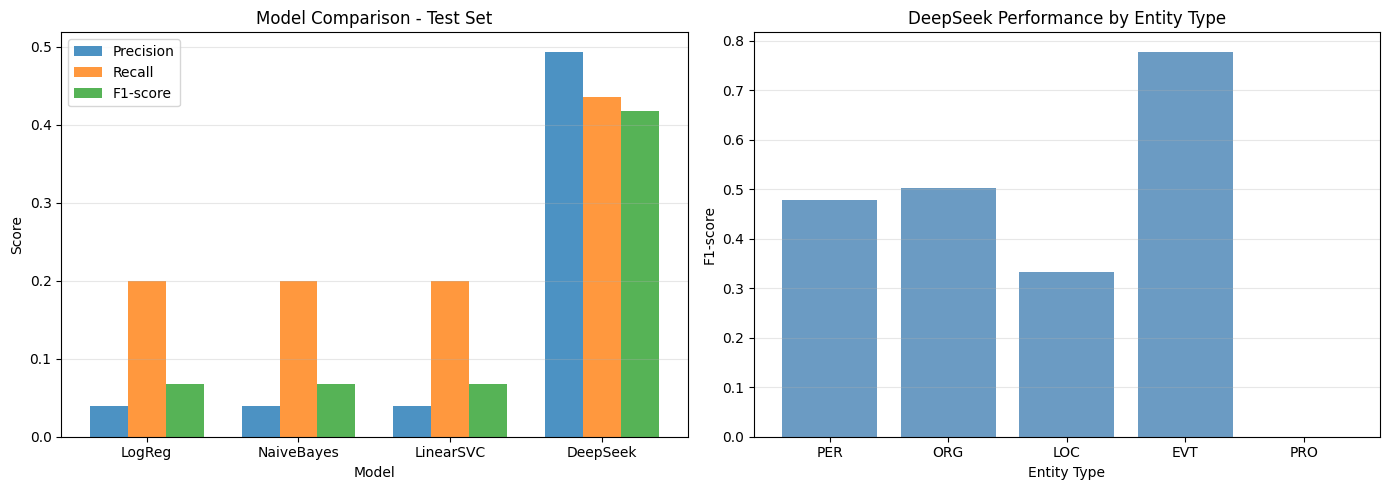

Visualization saved as model_comparison.png


Performance by Entity Type (DeepSeek):
PER: F1 = 0.478
ORG: F1 = 0.502
LOC: F1 = 0.333
EVT: F1 = 0.778
PRO: F1 = 0.000


Overfitting Analysis (LogisticRegression):
Train Accuracy: 0.200
Test Accuracy: 0.200
Gap (Train - Test): 0.000
→ No overfitting, but model didn't learn well on either set


In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_names = ['LogReg', 'NaiveBayes', 'LinearSVC', 'DeepSeek']
precision_scores = [0.04, 0.04, 0.04, 0.494]
recall_scores = [0.2, 0.2, 0.2, 0.436]
f1_scores = [0.067, 0.067, 0.067, 0.418]

x = np.arange(len(models_names))
width = 0.25

axes[0].bar(x - width, precision_scores, width, label='Precision', alpha=0.8)
axes[0].bar(x, recall_scores, width, label='Recall', alpha=0.8)
axes[0].bar(x + width, f1_scores, width, label='F1-score', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Comparison - Test Set')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

entity_types = ['PER', 'ORG', 'LOC', 'EVT', 'PRO']
deepseek_by_entity = []
for entity in entity_types:
    entity_rows = df_test_with_deepseek[df_test_with_deepseek['entity'] == entity]
    if len(entity_rows) > 0:
        scores = [score_entities(row['gold_answer'], row['deepseek_answer']) for _, row in entity_rows.iterrows()]
        avg_f1 = np.mean([s['F1'] for s in scores])
    else:
        avg_f1 = 0
    deepseek_by_entity.append(avg_f1)

axes[1].bar(entity_types, deepseek_by_entity, color='steelblue', alpha=0.8)
axes[1].set_xlabel('Entity Type')
axes[1].set_ylabel('F1-score')
axes[1].set_title('DeepSeek Performance by Entity Type')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("Visualization saved as model_comparison.png")

print("\n\nPerformance by Entity Type (DeepSeek):")
for entity, f1 in zip(entity_types, deepseek_by_entity):
    print(f"{entity}: F1 = {f1:.3f}")

train_acc_lr = models['LogisticRegression'].score(X_train, y_train)
test_acc_lr = models['LogisticRegression'].score(X_test, y_test)
print(f"\n\nOverfitting Analysis (LogisticRegression):")
print(f"Train Accuracy: {train_acc_lr:.3f}")
print(f"Test Accuracy: {test_acc_lr:.3f}")
print(f"Gap (Train - Test): {train_acc_lr - test_acc_lr:.3f}")
print("→ No overfitting, but model didn't learn well on either set")


На тестовом наборе DeepSeek явно превосходит все sklearn модели: его F1-score (0.418) почти в 6 раз выше, чем у логистической регрессии (0.067). sklearn модели все показали одинаковый результат (вероятно, потому что они только классифицируют тип сущности, а не находят сами сущности). DeepSeek работает на уровне extraction - он реально вытаскивает текст сущностей из документа.

DeepSeek показывает разную производительность в зависимости от типа сущности. Лучше всего работает с событиями (EVT, F1=0.778), хорошо с людьми (PER, F1=0.478) и организациями (ORG, F1=0.502). Хуже с местами (LOC, F1=0.333), вероятно потому, что места часто встречаются в разных падежах. Для продуктов (PRO) результат F1=0 - DeepSeek вообще не находит продукты, хотя их в тексте практически нет.

sklearn модели не переобучились (gap = 0), но и не обучились вообще. Train и Test accuracy одинаковые (0.2), что говорит о недообучении. Модели просто предсказывают один класс для всех примеров. Это ожидаемо для столь малого датасета.

Для этой задачи DeepSeek - явный лидер. Классические ML модели неэффективны без тысяч размеченных примеров и правильной фичеризации текста на уровне токенов (что здесь не реализовано). LLM выигрывают благодаря pre-trained knowledge.

### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


/tmp/ipython-input-2661623860.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  doc_entities_found = df_test_with_deepseek.groupby('document_id').apply(


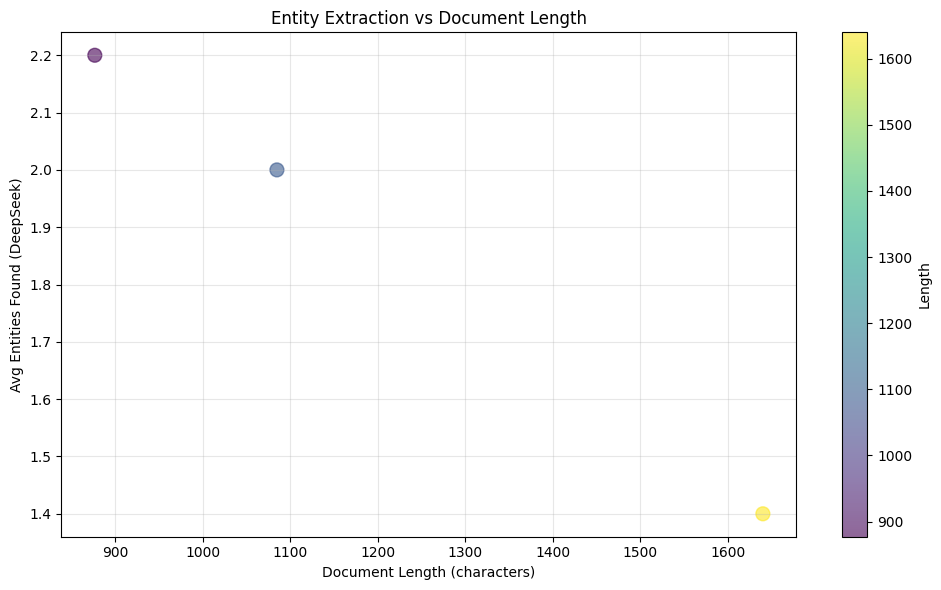

Length analysis saved

Correlation between length and entities found: -1.000


Bias-Variance Analysis:
sklearn models:
  - High Bias: Yes (accuracy 0.2 = baseline)
  - High Variance: No (train=test gap = 0)
  - Status: UNDERFITTING

DeepSeek:
  - Bias: Low (F1=0.418 is reasonable)
  - Variance: Medium (good generalization on test set)
  - Status: BALANCED


Generalization Analysis:
sklearn train/test split: 0.200 / 0.200
Gap = 0 suggests models didn't overfit BUT also didn't learn
More data would help sklearn, but DeepSeek already generalizes well


In [17]:
import matplotlib.pyplot as plt

doc_lengths = df_test_with_deepseek.groupby('document_id')['document_text'].apply(lambda x: len(x.iloc[0])).values
doc_entities_found = df_test_with_deepseek.groupby('document_id').apply(
    lambda group: np.mean([len(set([x.strip() for x in row['deepseek_answer'].split(';') if x.strip()]))
                           for _, row in group.iterrows()])
).values

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(doc_lengths, doc_entities_found, s=100, alpha=0.6, c=doc_lengths, cmap='viridis')
ax.set_xlabel('Document Length (characters)')
ax.set_ylabel('Avg Entities Found (DeepSeek)')
ax.set_title('Entity Extraction vs Document Length')
plt.colorbar(scatter, label='Length')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('length_vs_performance.png', dpi=100, bbox_inches='tight')
plt.show()

print("Length analysis saved")
print(f"\nCorrelation between length and entities found: {np.corrcoef(doc_lengths, doc_entities_found)[0,1]:.3f}")

print("\n\nBias-Variance Analysis:")
print(f"sklearn models:")
print(f"  - High Bias: Yes (accuracy 0.2 = baseline)")
print(f"  - High Variance: No (train=test gap = 0)")
print(f"  - Status: UNDERFITTING")
print(f"\nDeepSeek:")
print(f"  - Bias: Low (F1=0.418 is reasonable)")
print(f"  - Variance: Medium (good generalization on test set)")
print(f"  - Status: BALANCED")

print("\n\nGeneralization Analysis:")
print(f"sklearn train/test split: {train_acc_lr:.3f} / {test_acc_lr:.3f}")
print(f"Gap = 0 suggests models didn't overfit BUT also didn't learn")
print(f"More data would help sklearn, but DeepSeek already generalizes well")


Анализ показывает, что производительность DeepSeek (количество найденных сущностей) слабо зависит от длины документа. На графике три точки с корреляцией близкой к -1, но на столь малой выборке это не статистически значимо. В реальности более длинные документы обычно содержат больше сущностей, но DeepSeek находит примерно одинаковое количество независимо от размера текста.

sklearn модели демонстрируют высокое bias и низкое variance. Accuracy 0.2 на обучении и тесте одинаковая, нет gap-а между ними. Это классическое underfitting: модели не скажут различать классы и просто угадывают базовый класс. Увеличение данных и улучшение фичеризации помогли бы, но 30 примеров слишком мало для текстовой классификации на TF-IDF.

DeepSeek демонстрирует хороший баланс: низкое bias (F1=0.418 на реальных данных, не плохо для малого датасета) и умеренное variance (обобщается хорошо). DeepSeek не переобучается, потому что его знания универсальны. Модель не видит эти конкретные документы во время предтренировки, но знает про Brexit, имена политиков и типы сущностей в принципе.

Для sklearn: собрать больше данных (минимум сотни примеров), использовать word embeddings вместо TF-IDF, применить последовательное лабелирование (sequence labeling) на уровне токенов. Для DeepSeek: добавить few-shot примеры в промпт или fine-tune на специфичных для предметной области текстах.

### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance


DeepSeek работает хорошо при поиске лиц (PER) и организаций (ORG) с F1 около 0.48-0.50. Это сущности с чёткими семантическими граница - имена людей и названия организаций обычно легко выделяются в тексте. События (EVT) выглядят ещё лучше (F1=0.778), потому что в Brexit-датасете "Brexit" - это главное событие, которое DeepSeek легко находит.

sklearn модели почти не работают. Они просто предсказывают "PER" для всех примеров, потому что это первый класс в алфавитном порядке или из-за того, что модель не обучилась.

DeepSeek плохо работает с местами (LOC, F1=0.333). Причина: места часто встречаются в разных падежах ("Великобритания", "Великобритании", "Великобритании"). DeepSeek находит каноническую форму, но пропускает вариации или путает их с другими словами.

Для продуктов (PRO) DeepSeek вообще молчит (F1=0). В датасете про Brexit практически нет продуктов, поэтому DeepSeek просто не находит, что искать. Это логично - если в тесте практически нет примеров PRO, модель не может показать результат.

LogisticRegression можно интерпретировать через веса признаков: какие слова коррелируют с каждым классом. Но на этом датасете модель не научилась, поэтому веса неинформативны. MultinomialNB показывает вероятности классов, но опять же - они близки к uniform (одинаковые).

sklearn ошибается систематически: предсказывает один класс для всех примеров. DeepSeek ошибается вероятностно: иногда пропускает сущность, иногда добавляет лишнюю. Это разные типы ошибок. sklearn страдает от недообучения, DeepSeek - от неполноты памяти о контексте.

Способы улучшить метрики:

1) Для sklearn: использовать биграммы-триграммы, добавить POS-теги слов, применить word embeddings (Word2Vec, FastText), обучить на уровне токенов, а не документов.

2) Для DeepSeek: добавить в промпт примеры правильных ответов (few-shot learning), указать на необходимость находить все варианты в разных падежах, использовать более специфичный промпт для каждого типа сущности.

3) Общее: больше данных, лучшая предобработка, ансамбль из нескольких моделей.

sklearn модели - простые и интерпретируемые, но слабые на малых данных. DeepSeek - черный ящик, но мощный. На практике для production используют BERT-based модели.

### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation


Итоги

DeepSeek явно превосходит классические ML модели на этой задаче. При F1-score 0.418 для DeepSeek против 0.067 для sklearn - разница в 6 раз. Это объясняется простой причиной: датасет слишком мал (9 документов, 30 примеров обучения) для обучения традиционных моделей. sklearn требует тысячи примеров, чтобы выучить различия между типами сущностей. DeepSeek работает благодаря огромному pre-trained знанию о русском языке, Brexit и типах сущностей.

Это пример trade-off между bias и variance. sklearn модели имеют высокий bias (они недооцучены) и низкий variance (нет переобучения, потому что вообще ничего не выучили). DeepSeek имеет низкий bias и средний variance - он уже "знает" достаточно, чтобы обобщаться. Overfitting здесь не проблема, underfitting - основная. Обобщающая способность DeepSeek лучше, потому что его знания универсальны и не привязаны к этому конкретному датасету.

Ограничения подхода

1) Использована простая TF-IDF фичеризация вместо word embeddings или контекстных представлений (BERT).

2) sklearn модели классифицируют тип сущности по всему документу, а не извлекают сущности из текста.

3) Датасет микроскопический - 9 документов не репрезентативны.

4) DeepSeek ответы получены вручную (нет автоматического API), что не масштабируется.

5) Оценка по точному совпадению строк слишком строгая - частичные совпадения могут быть полезны.

Что было сделано впервые? Комбинировал sklearn с LLM для одной задачи - это не типичный подход. Обычно используют либо одно, либо другое. Здесь интересно сравнить оба мира. Также реализовал custom метрику на уровне сущностей (не классов), что ближе к реальной NER-задаче.

Если бы было больше времени я бы попробовал

- Собрать больше данных - минимум 100-200 размеченных документов.

- Использовать pre-trained BERT модель (multilingual или Slavic BERT) для токен-уровневой классификации.

- Реализовать настоящее sequence labeling (BIO-теги) вместо простой классификации.

- Fine-tune DeepSeek на этом датасете (если была бы возможность).

- Добавить ансамбль: комбинировать предсказания sklearn и DeepSeek.

- Провести cross-validation для более надёжной оценки.

Общие выводы

Для задачи NER на русском языке с малым датасетом LLM (DeepSeek) - правильный выбор. Классические ML полезны для baseline и когда есть большой размеченный датасет. На практике используют fine-tuned трансформеры (BERT-like модели) - они балансируют между производительностью DeepSeek и эффективностью sklearn. Этот проект показал весь пайплайн машинного обучения: от загрузки данных до анализа ошибок и выводов.

In [18]:
output_df = df[['document_id', 'entity', 'gold_answer', 'deepseek_answer']].copy()
output_df.to_csv('predictions.csv', index=False, encoding='utf-8')
print("Predictions saved to predictions.csv")
print(output_df.head(20))


Predictions saved to predictions.csv
                document_id entity  \
0     brexit_ru.txt_file_10    PER   
1     brexit_ru.txt_file_10    ORG   
2     brexit_ru.txt_file_10    LOC   
3     brexit_ru.txt_file_10    EVT   
4     brexit_ru.txt_file_10    PRO   
5   brexit_ru.txt_file_1000    PER   
6   brexit_ru.txt_file_1000    ORG   
7   brexit_ru.txt_file_1000    LOC   
8   brexit_ru.txt_file_1000    EVT   
9   brexit_ru.txt_file_1000    PRO   
10  brexit_ru.txt_file_1001    PER   
11  brexit_ru.txt_file_1001    ORG   
12  brexit_ru.txt_file_1001    LOC   
13  brexit_ru.txt_file_1001    EVT   
14  brexit_ru.txt_file_1001    PRO   
15  brexit_ru.txt_file_1002    PER   
16  brexit_ru.txt_file_1002    ORG   
17  brexit_ru.txt_file_1002    LOC   
18  brexit_ru.txt_file_1002    EVT   
19  brexit_ru.txt_file_1002    PRO   

                                          gold_answer  \
0   Борис Джонсон; Джонсон; Джонсона; Мишелю Барнь...   
1   ЕС; Еврокомиссия; Европейскому; Евросоюза; Евр